# Manuscript Content

This notebook generates all of the figures and tables for the manuscript exploring the indicators derived from the algorithm developed in this repository and their relationship with the indicators in the NSIDC-0747 dataset, currently referred to as the "Bliss" indicators throughout. And appendix is provided at the end of this document. 

This notebook is structured so as to create a single piece of content (e.g. figure) with each cell, and is designed such that all cells are independent of one another except the very first code cell which needs to be run before any of the following cells. 

In [9]:
import os
import time
import datetime as dt
from pathlib import Path
import mc_setup as mcs
import mc_functions as mcf

# allow printing to terminal
terminal_output = open("/dev/stdout", "w")
mcf.terminal_output = terminal_output

# setup environment and handle all file-pathing
# allow importing relative to PROJECT_DIR
# by cd-ing to PROJECT_DIR
# project_dir = os.getenv("PROJECT_DIR")
# %cd -q "$project_dir"


base_dir = Path(os.getenv("BASE_DIR") or "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/")
output_dir = Path(os.getenv("OUTPUT_DIR") or "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/")
scratch_dir = Path(os.getenv("SCRATCH_DIR") or "/atlas_scratch/kmredilla/seaice_noaa_indicators")

# make the output directory for this notebook if not present
content_dir = output_dir.joinpath("manuscript_content")
content_dir.mkdir(exist_ok=True)

# make ancillary dir
anc_dir = base_dir.joinpath("ancillary")
anc_dir.mkdir(parents=True, exist_ok=True)

# use the FUBU data file created as a product of the pipeline
fubu_fp = output_dir.joinpath("arctic_seaice_fubu_dates_1979-2019.nc")
orac_fp = anc_dir.joinpath(
    "arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc"
)
masie_fp = anc_dir.joinpath("MASIE_regions_polygon_vertices.xlsx")
poi_coords_fp = base_dir.joinpath("ancillary/points_of_interest.csv")
gshhs_fp = anc_dir.joinpath("GSHHS_shp/i/GSHHS_i_L1.shp")
seamask_fp = scratch_dir.joinpath("seamask_3411.tif")

# make input filepaths global in setup module
mcs.fubu_fp = fubu_fp
mcs.orac_fp = orac_fp
mcs.masie_fp = masie_fp
mcs.poi_coords_fp = poi_coords_fp
mcs.gshhs_fp = gshhs_fp
mcs.seamask_fp = seamask_fp

## Download ancillary data

Download the ancillary data files needed for running analyses and creating the manuscript content:  
1. NSIDC-0747 indicators data
2. the MASIE region vertices from NSIDC
3. GSHHG world shoreline polygons from NCEI

### NSIDC-0747 dataset

In [4]:
# User parameters
# set clobber to True to download even if NSIDC-0747 
#   dataset exists locally.
clobber = False

import pipeline.download_nsidc as dsic

def download_nsidc0747():
    print("Downloading NSIDC-0747 dataset", file=terminal_output, flush=True)
    out_0747_fp = dsic.cmr_download([nsidc0747_url], anc_dir)
    print(f"NSIDC-0747 written to {out_0747_fp}", file=terminal_output, flush=True)
    
    return


dsic.cmr_url = "https://cmr.earthdata.nasa.gov"
dsic.urs_url = "https://urs.earthdata.nasa.gov"

# next, download NSIDC-0747
nsidc0747_url = "https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0747_seaice_melt_indicators_v1/arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc"
if not clobber:
    if not orac_fp.exists():
        download_nsidc0747()
    else:
        print("NSIDC-0747 data already present in $BASE_DIR", file=terminal_output, flush=True)
else:
    download_nsidc0747()
    
print(
    f"NSIDC-0747 check/download completed at {dt.datetime.utcfromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')}",
    file=terminal_output,
    flush=True
)

NSIDC-0747 data already present in $BASE_DIR
NSIDC-0747 check/download completed at 2021-10-07 20:02:42


### MASIE region vertices

For use in various analyses.

In [14]:
# User parameters
# set clobber to True to download even if MASIE 
#   dataset exists locally.
clobber = False

import ssl
from download_ancillary import run_download

def download_masie():
    print("Downloading MASIE vertices...", file=terminal_output, flush=True)
    run_download(masie_url, masie_fp)
    print(f"MASIE region vertices written to {masie_fp}", file=terminal_output, flush=True)
    
    return


# download MASIE region vertices
masie_url = "https://masie_web.apps.nsidc.org/pub/DATASETS/NOAA/G02186/ancillary/MASIE_regions_polygon_vertices.xlsx"

# this seems to be necessary to avoid SSL_CERTIFICATE_VERIFY_FAILED error
ssl._create_default_https_context = ssl._create_unverified_context

if not clobber:
    if not masie_fp.exists():
        download_masie()
    else:
        print("MASIE region vertices already present in $BASE_DIR", file=terminal_output, flush=True)
else:
    download_masie()
    
print(
    (f"MAISE region vertices check/download completed at "
     f"{dt.datetime.utcfromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')}"),
    file=terminal_output,
    flush=True
)

MASIE region vertices written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/MASIE_regions_polygon_vertices.xlsx
MAISE region vertices check/download completed at 2021-10-07 23:38:43


### NSIDC-G02195

There are two files available in this dataset - one for 1968-1990 and one for 1991-1998. Setup:

In [60]:
%cd -q /workspace/UA/kmredilla/seaice_noaa_indicators
import pipeline.download_nsidc as dsic

def download_nsidc_G02195(fn):
    url = f"https://daacdata.apps.nsidc.org/pub/DATASETS/NOAA/G02195/{fn}"
    print("Downloading NSIDC-G02195 dataset", file=terminal_output, flush=True)
    out_di = dsic.cmr_download([url], anc_dir)
    print(f"NSIDC-G02195 dataset written to {out_di[url]}", file=terminal_output, flush=True)
    
    return

1968 - 1990 is `lfi_mo_ave_68-90.nc`:

In [61]:
# landfast ice for 68-90
download_nsidc_G02195("lfi_mo_ave_68-90.nc")

Earthdata username:  kredilla
password:  ··············


1/1: /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/lfi_mo_ave_68-90.nc
https://daacdata.apps.nsidc.org/pub/DATASETS/NOAA/G02195/lfi_mo_ave_68-90.nc
NSIDC-G02195 dataset written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/lfi_mo_ave_68-90.nc


1991 - 1998 is `lfi_mo_ave_91-98.nc`:

In [62]:
# landfast ice for 91-98
download_nsidc_G02195("lfi_mo_ave_91-98.nc")

Earthdata username:  kredilla
password:  ··············


1/1: /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/lfi_mo_ave_91-98.nc
https://daacdata.apps.nsidc.org/pub/DATASETS/NOAA/G02195/lfi_mo_ave_91-98.nc
NSIDC-G02195 dataset written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/lfi_mo_ave_91-98.nc


## Maps setup

Run the cell below before executing any of the cells that create either of the totals maps, the ice season length maps, or the mean date lag maps. 

In [2]:
def maps_setup():
    """Setup the environment for maps creation. 
    Data needed: FUBU dates, Bliss indicator dates, and landmask in EPSG:3411.
    
    Returns:
        Checks to see whether all required variables are defined, 
        and does so if not.
    """
    global fubu
    global orac
    global landmask
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)
    
    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)

    try: landmask
    except NameError:
        landmask = mcf.get_landmask(orac_fp)
        
    return

## Definition totals maps

Create maps of the study area where grid cells are colored by counts of the number of years an indicator was defined. Creates one set of totals maps for each indicator dataset.

#### J&E totals maps

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Johnson_Eicken_totals_maps.png at 2021-10-07 17:12:20


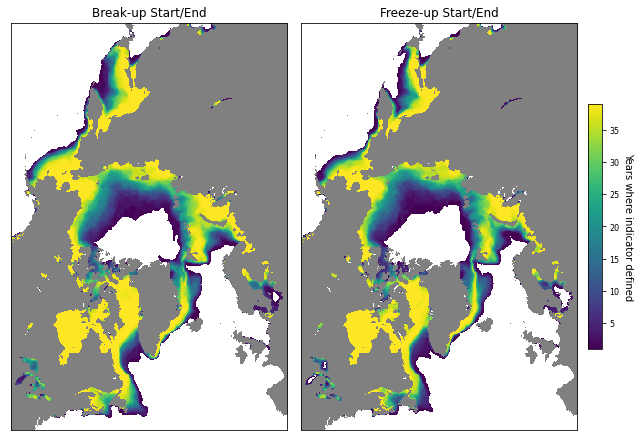

In [3]:
print("Creating J&E totals maps", file=terminal_output, flush=True, end="...")

maps_setup()

output_format = "png"
#output_format = "eps"

mcf.make_totals_maps(
    fubu,
    ["breakup_start", "freezeup_start"],
    landmask,
    ["Break-up Start/End", "Freeze-up Start/End"],
    content_dir.joinpath(f"Johnson_Eicken_totals_maps.{output_format}"),
)

#### Bliss et al. totals maps

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Bliss_totals_maps.png


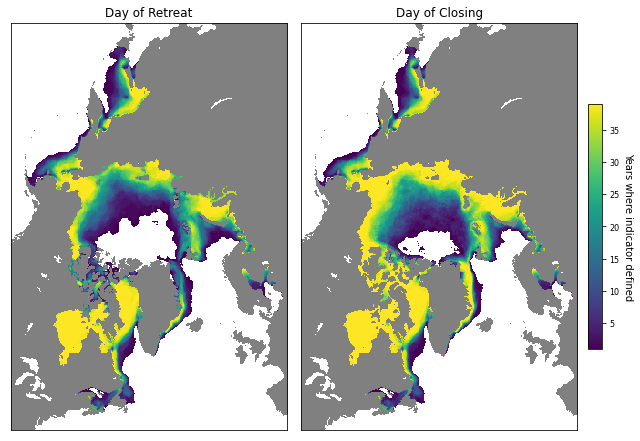

In [4]:
print("Creating Bliss et al totals maps", file=terminal_output, flush=True, end="...")

maps_setup()

output_format = "png"
#output_format = "eps"

mcf.make_totals_maps(
    orac,
    ["DOR", "DOC"],
    landmask,
    ["Day of Retreat", "Day of Closing"],
    content_dir.joinpath(f"Bliss_totals_maps.{output_format}"),
)

## Ice season length maps

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/ice_season_length_maps.png


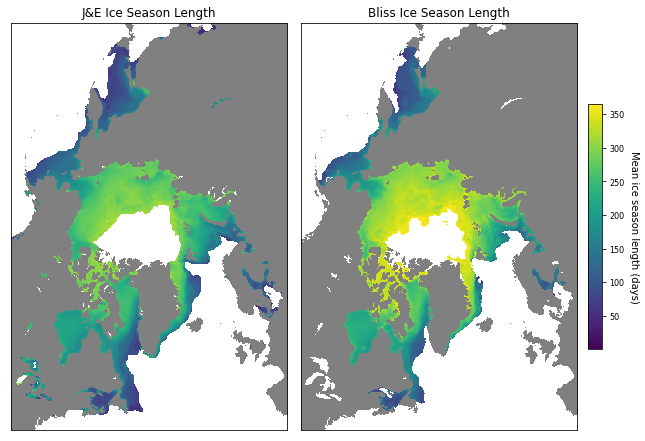

In [4]:
print("Creating ice season length maps", file=terminal_output, flush=True, end="...")

maps_setup()

output_format = "png"
#output_format = "eps"

mcf.make_isl_maps(
    fubu,
    orac,
    landmask,
    content_dir.joinpath(f"ice_season_length_maps.{output_format}")
)

## Mean date lag maps

Create maps depicting the mean difference in indicator dates for corresponding indicators between J&E and Bliss et al datasets. Differences computed as $mean( JE - Bliss)$

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/mean_date_lag_maps.png


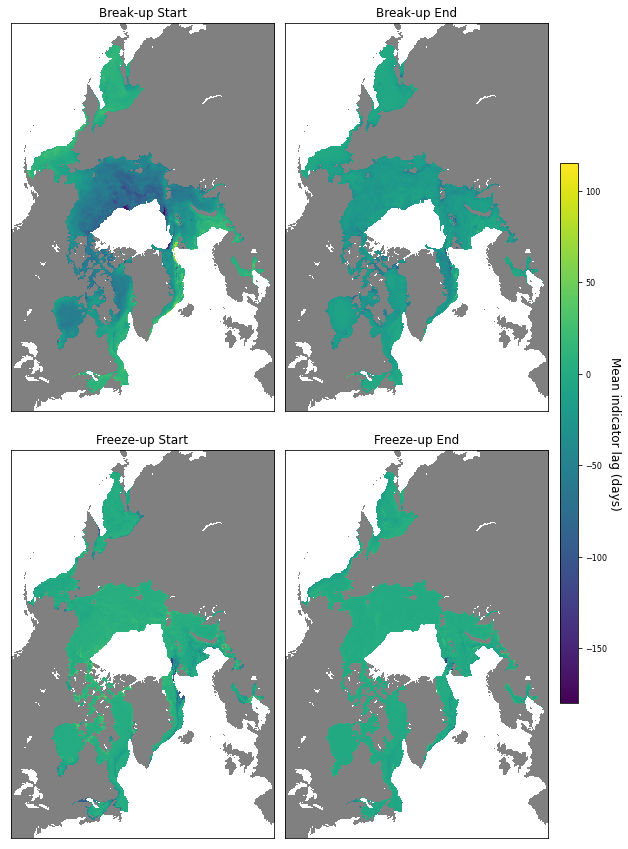

In [4]:
print("Creating mean date lag maps", file=terminal_output, flush=True, end="...")

maps_setup()

output_format = "png"
#output_format = "eps"

mcf.make_date_lag_maps(
    fubu,
    orac,
    landmask,
    content_dir.joinpath(f"mean_date_lag_maps.{output_format}")
)

## MASIE region zonal stats results

Summarize the indicators for each dataset by mean date and definition rate. Mean day of year is the mean of the indicator ordinal date for years where the indicator was defined. Definition rate is the percentage of years for which the indicator was defined. All values are on pixel-wise basis. 

In [9]:
print("Running zonal statistics on MAISE regions", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

try: fubu
except NameError: 
    fubu = mcf.load_fubu(fubu_fp)

try: orac
except NameError: 
    orac = mcf.load_orac(orac_fp, fubu)
    
try: masie_polys
except NameError:
    masie_polys = mcf.get_masie_polys(masie_fp)

try: affine
except NameError:
    affine = mcf.get_fubu_affine(fubu_fp)

zs_df = mcf.run_zonal_stats(fubu, orac, masie_polys, affine)

zs_df

print(f"done, {round(time.perf_counter() - tic)}s", file=terminal_output, flush=True)

,region,mean_date,def_rate,year,indicator,group,indicator_type,indicator_event,fubu_indicator
0,Beaufort Sea,289.241573,12.1,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
1,Chukchi Sea,300.845802,19.3,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
2,E. Siberian Sea,266.102564,1.6,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
3,Laptev Sea,265.295455,4.2,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
4,Kara Sea,288.731876,16.9,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
...,...,...,...,...,...,...,...,...,...
3739,Baffin Bay,328.444676,8.2,2017,Day of Closing,Bliss,freezeup,end,freezeup_end
3740,Canadian Arch.,275.981520,15.2,2017,Day of Closing,Bliss,freezeup,end,freezeup_end
3741,Hudson Bay,337.186902,36.2,2017,Day of Closing,Bliss,freezeup,end,freezeup_end
3742,Central Arctic,289.920455,9.3,2017,Day of Closing,Bliss,freezeup,end,freezeup_end


## Violin plot setup

Run the cell below before running any of the cells which generate violin plot or histogram figures.

In [2]:
def violinplot_setup():
    global fubu
    global orac
    global masie_polys
    global affine
    global zs_df
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)

    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)

    try: masie_polys
    except NameError:
        masie_polys = mcf.get_masie_polys(masie_fp)

    try: affine
    except NameError:
        affine = mcf.get_fubu_affine(fubu_fp)
    
    try: zs_df
    except NameError:
        zs_df = mcf.run_zonal_stats(fubu, orac, masie_polys, affine)

## Violin plots

Create violin plots that are grouped by indicator and colored by dataset using the MASIE-based zonal summaries. 

### Mean day of year violin plots

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/mean_doy_violin_plots.png


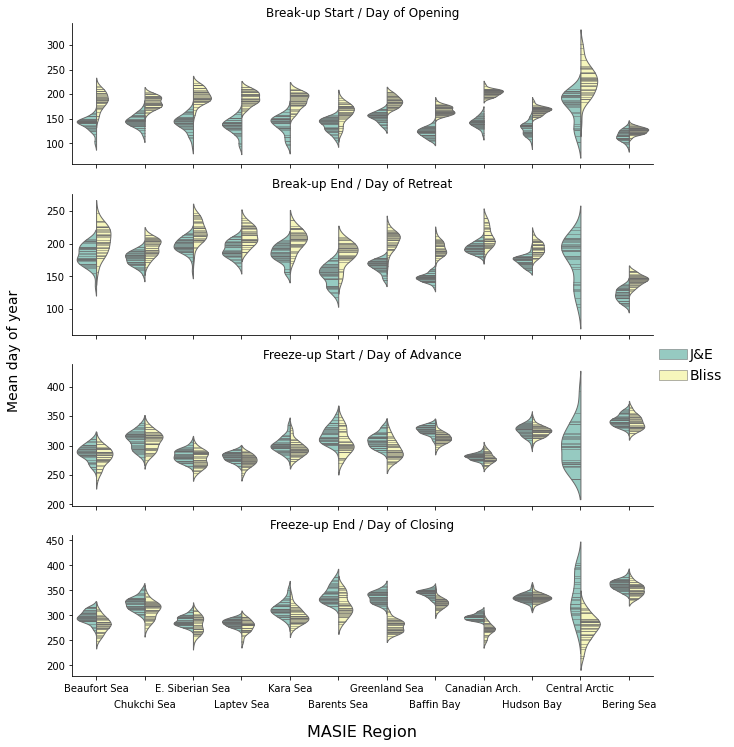

In [3]:
print("Creating mean day-of-year violin plots", file=terminal_output, flush=True, end="...")

violinplot_setup()

output_format = "png"
# output_format = "eps"

mcf.make_violin_plots(
    zs_df,
    "mean_date",
    "Set3",
    "Mean day of year",
    content_dir.joinpath(f"mean_doy_violin_plots.{output_format}"),
)

### Definition rate violin plots

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/definition_rate_violin_plots.png


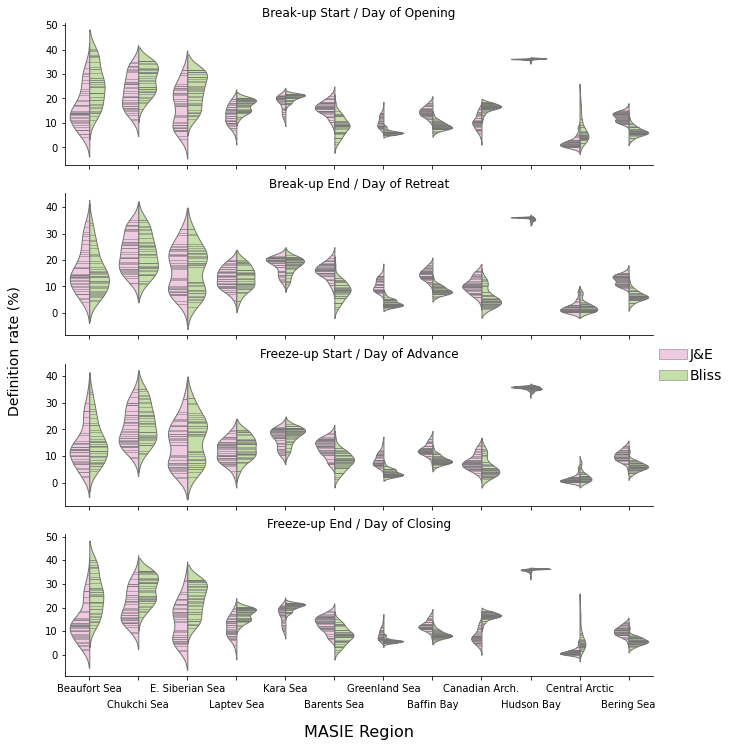

In [4]:
print("Creating definition rate violin plots", file=terminal_output, flush=True, end="...")

violinplot_setup()

output_format = "png"
# output_format = "eps"

mcf.make_violin_plots(
    zs_df,
    "def_rate",
    "PiYG",
    "Definition rate (%)",
    content_dir.joinpath(f"definition_rate_violin_plots.{output_format}"),
)

## MASIE mean date histograms

Generate histograms of mean indicator dates for a subset of MASIE regions.

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_mean_histograms.png


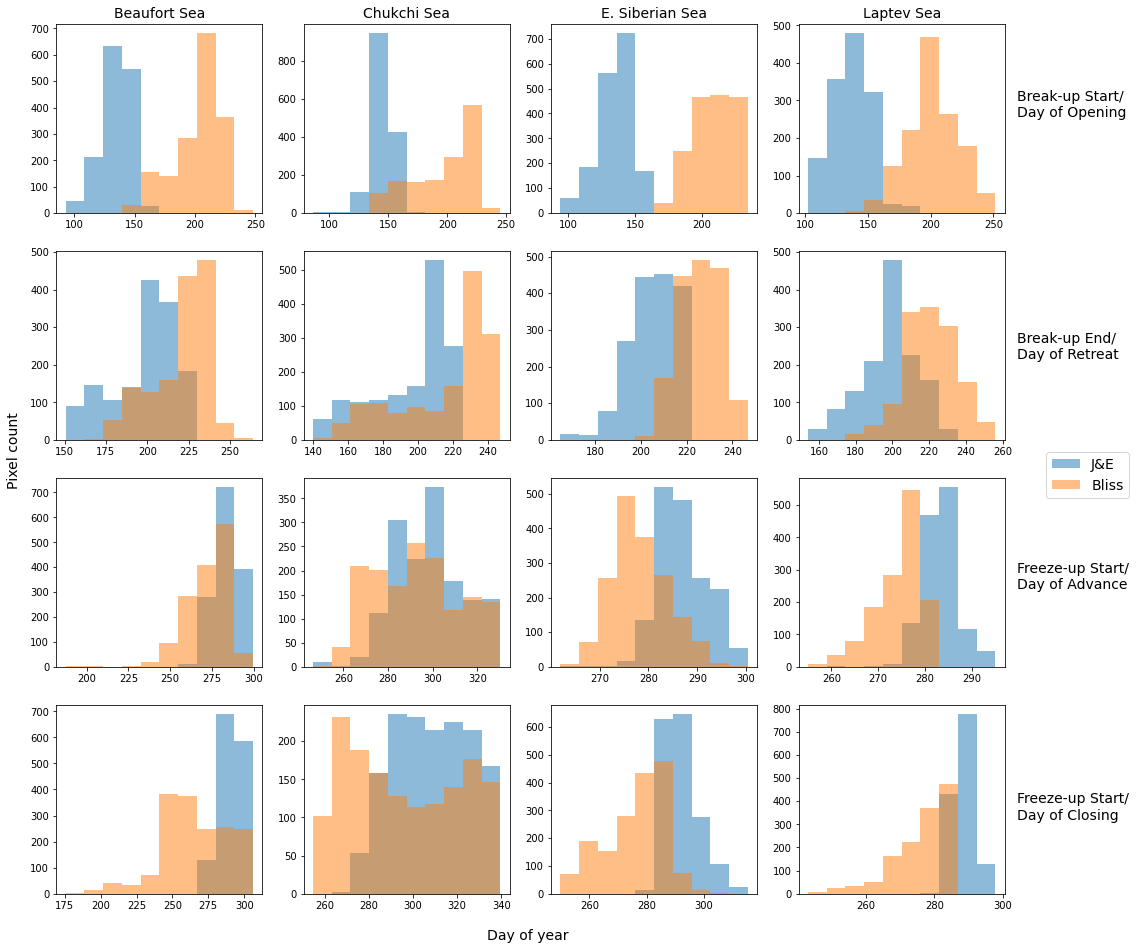

In [7]:
print("Creating MASIE mean date histograms", file=terminal_output, flush=True, end="...")

violinplot_setup()

output_format = "png"
# output_format = "eps"

mcf.make_masie_mean_histograms(
    fubu, 
    orac, 
    masie_polys, 
    affine, 
    content_dir.joinpath(f"masie_mean_histograms.{output_format}")
)

## Maps for pixel selections for points of interest

Maps depicting the pixels chosen for aggregating values to represent points of interest.

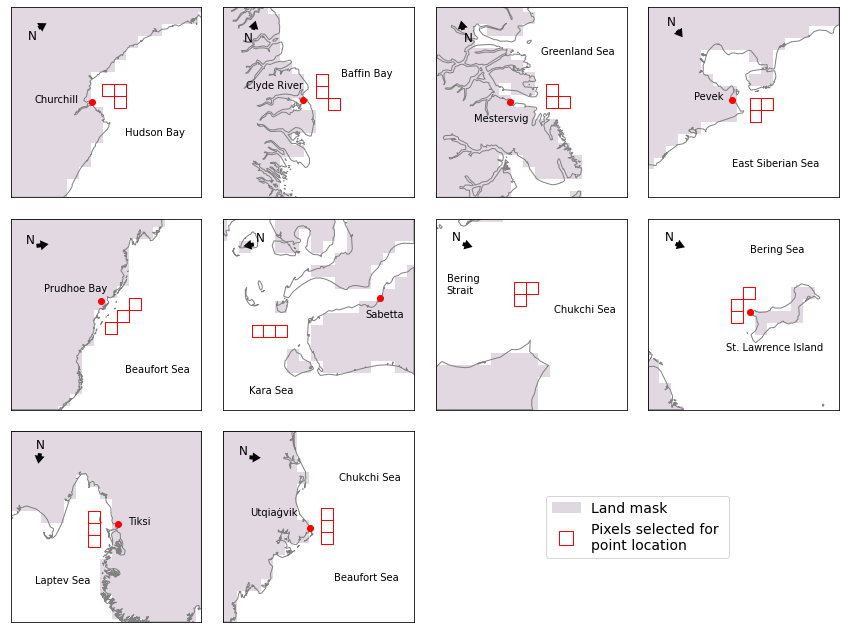

In [2]:
print("Creating maps for pixel selections for points-of-interest", file=terminal_output, flush=True, end="...")

# Point of interest maps setup
try: fubu
except NameError: 
    fubu = mcf.load_fubu(fubu_fp)

try: orac
except NameError: 
    orac = mcf.load_orac(orac_fp, fubu)

try: poi_coords
except NameError:
    poi_coords = mcf.load_poi_coords(poi_coords_fp)

try: world_shore
except NameError:
    world_shore = mcf.load_world_shore(gshhs_fp)

try: seamask_src
except NameError:
    seamask_src = mcf.load_seamask(seamask_fp)


output_format = "png"
# output_format = "eps"

mcf.make_poi_maps(
    poi_coords,
    world_shore,
    seamask_src,
    content_dir.joinpath(f"point_trends_maps.{output_format}")
)

## Points-of-interest trends setup

Run the cell below before running any of the cells which generate point-of-interest trends plots.

In [8]:
def poi_trends_setup():
    global fubu
    global orac
    global poi_coords
    global poi_data
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)

    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)

    try: poi_coords
    except NameError:
        poi_coords = mcf.load_poi_coords(poi_coords_fp)

    try: poi_data
    except NameError:
        poi_data = mcf.get_poi_data(poi_coords, fubu, orac)

## Trend analysis for points of interest

Regress indicator dates against year for the points of interest. Save plots and model fit results.

### Break-up start

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_breakup_start.png


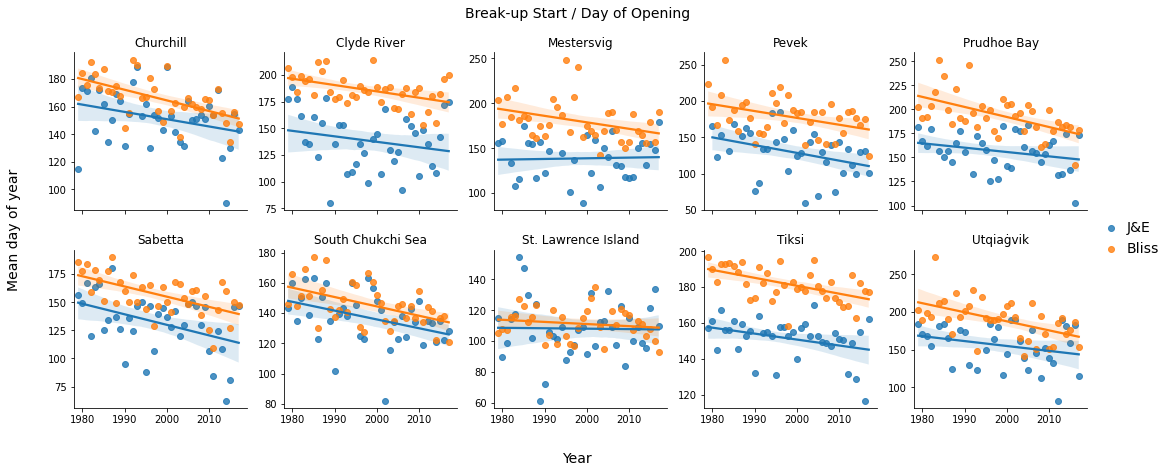

In [9]:
print("Creating break-up start point-of-interest indicator comparison trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

poi_trends_setup()

output_format = "png"
#output_format = "eps"

mcf.plot_poi_trends(
    poi_data, 
    "Break-up Start / Day of Opening", 
    content_dir, 
    output_format
)

### Break-up end

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_breakup_end.png


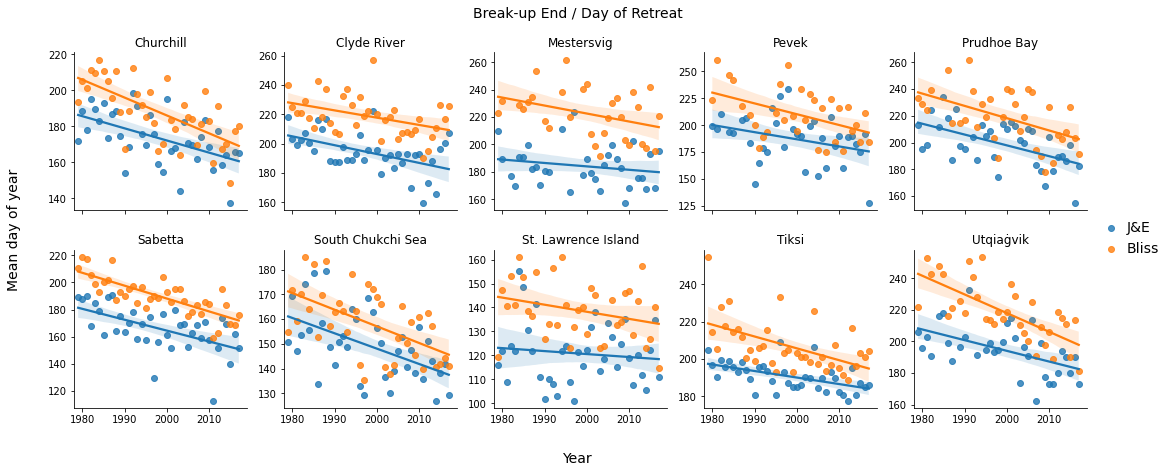

In [10]:
print("Creating break-up end point-of-interest indicator comparison trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

poi_trends_setup()

output_format = "png"
#output_format = "eps"

mcf.plot_poi_trends(
    poi_data, 
    "Break-up End / Day of Retreat", 
    content_dir, 
    output_format
)

### Freeze-up start

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_freezeup_start.png


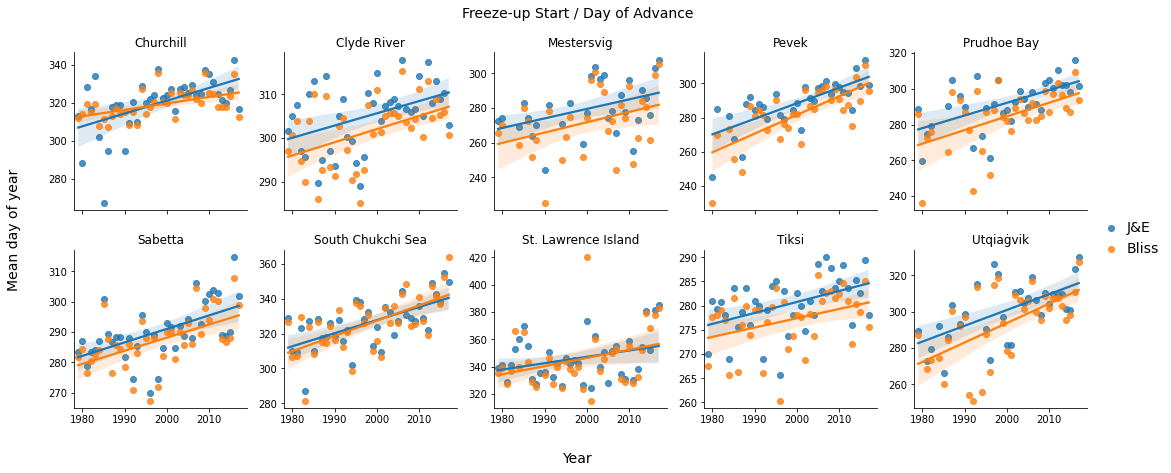

In [11]:
print("Creating freeze-up start point-of-interest indicator comparison trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

poi_trends_setup()

output_format = "png"
#output_format = "eps"

mcf.plot_poi_trends(
    poi_data, 
    "Freeze-up Start / Day of Advance", 
    content_dir, 
    output_format
)

### Freeze-up end

In [4]:
print("Creating freeze-up end point-of-interest indicator-comparison trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

poi_trends_setup()

output_format = "png"
#output_format = "eps"

mcf.plot_poi_trends(
    poi_data, 
    "Freeze-up End / Day of Closing", 
    content_dir, 
    output_format
)

Creating freeze-up end point-of-interest indicator-comparison trend plots...

NameError: name 'poi_trends_setup' is not defined

## Trends results for points of interest

In [10]:
print("Creating point-of-interest trends results table", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

poi_trends_setup()

poi_results_table = mcf.make_poi_results_table(
    poi_data, 
    content_dir.joinpath("point_trends_results_table.csv")
)

poi_results_table

Point trends results written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_results_table.csv


,Location,Indicator Group,Indicator,Slope,r2,p
0,Churchill,Bliss,Day of Advance,0.3,0.52,< 0.01**
1,Churchill,Bliss,Day of Closing,0.4,0.51,< 0.01**
2,Churchill,Bliss,Day of Opening,-0.8,-0.59,< 0.01**
3,Churchill,Bliss,Day of Retreat,-1.0,-0.67,< 0.01**
4,Churchill,J&E,Break-up End,-0.7,-0.54,< 0.01**
...,...,...,...,...,...,...
75,Utqiaġvik,Bliss,Day of Retreat,-1.2,-0.71,< 0.01**
76,Utqiaġvik,J&E,Break-up End,-0.7,-0.52,< 0.01**
77,Utqiaġvik,J&E,Break-up Start,-0.7,-0.27,0.11
78,Utqiaġvik,J&E,Freeze-up End,0.8,0.66,< 0.01**


## Points-of-interest / MASIE trends setup

Run the cell below before running any of the cells that generate MASIE - point-of-interest comparison trends plots.

In [14]:
def poi_masie_trends_setup():
    global fubu
    global orac
    global masie_polys
    global affine
    global zs_df
    global poi_coords
    global poi_data
    global poi_masie_df
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)

    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)
        
    try: masie_polys
    except NameError:
        masie_polys = mcf.get_masie_polys(masie_fp)

    try: affine
    except NameError:
        affine = mcf.get_fubu_affine(fubu_fp)
    
    try: zs_df
    except NameError:
        zs_df = mcf.run_zonal_stats(fubu, orac, masie_polys, affine)

    try: poi_coords
    except NameError:
        poi_coords = mcf.load_poi_coords(poi_coords_fp)

    try: poi_data
    except NameError:
        poi_data = mcf.get_poi_data(poi_coords, fubu, orac)
    
    try: poi_masie_df
    except NameError:
        poi_masie_df = mcf.concat_masie_poi_data(zs_df, poi_data)
        
    return poi_masie_df

## Trend analysis of MASIE region / point of interest comparison

Plot the trends of the points of interest against the MASIE region averages.

### Break-up start

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_breakup_start.png


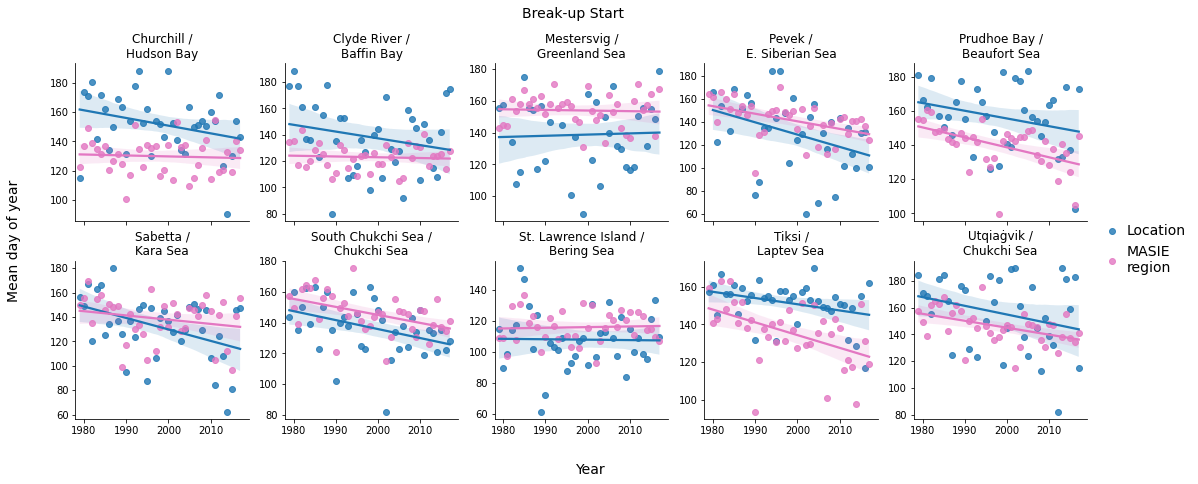

In [16]:
print("Creating break-up start point-of-interest / MASIE comparison trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

poi_masie_trends_setup()

output_format = "png"
#output_format = "eps"

mcf.make_masie_poi_trends_plots(
    poi_masie_df,
    "Break-up Start",
    content_dir,
    output_format,
)

### Break-up end

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_breakup_end.png


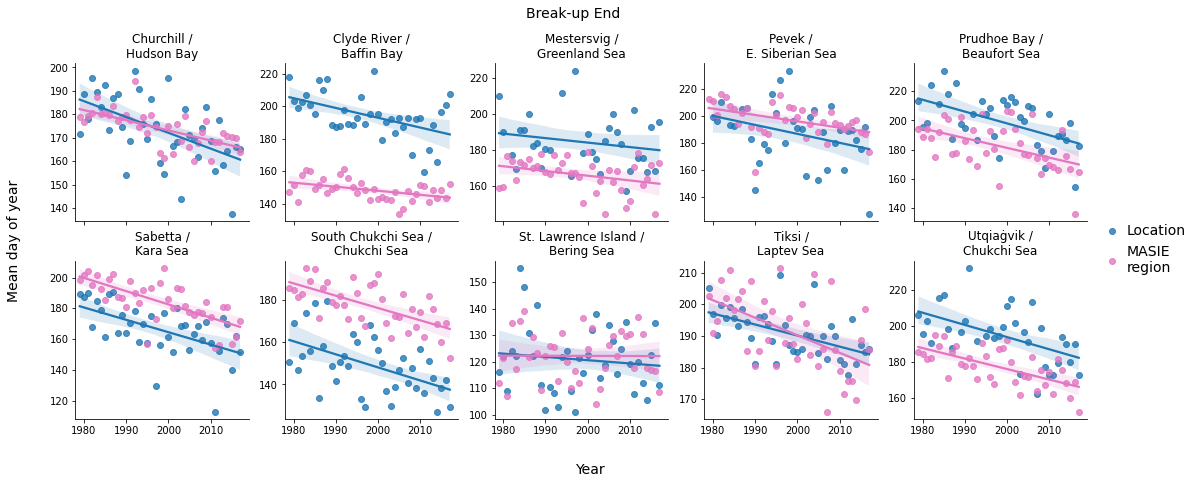

In [17]:
print("Creating break-up end point-of-interest / MASIE comparison trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

poi_masie_trends_setup()

output_format = "png"
#output_format = "eps"

indicator = "Break-up End"

mcf.make_masie_poi_trends_plots(
    poi_masie_df,
    indicator,
    content_dir,
    output_format,
)

### Freeze-up start

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_freezeup_start.png


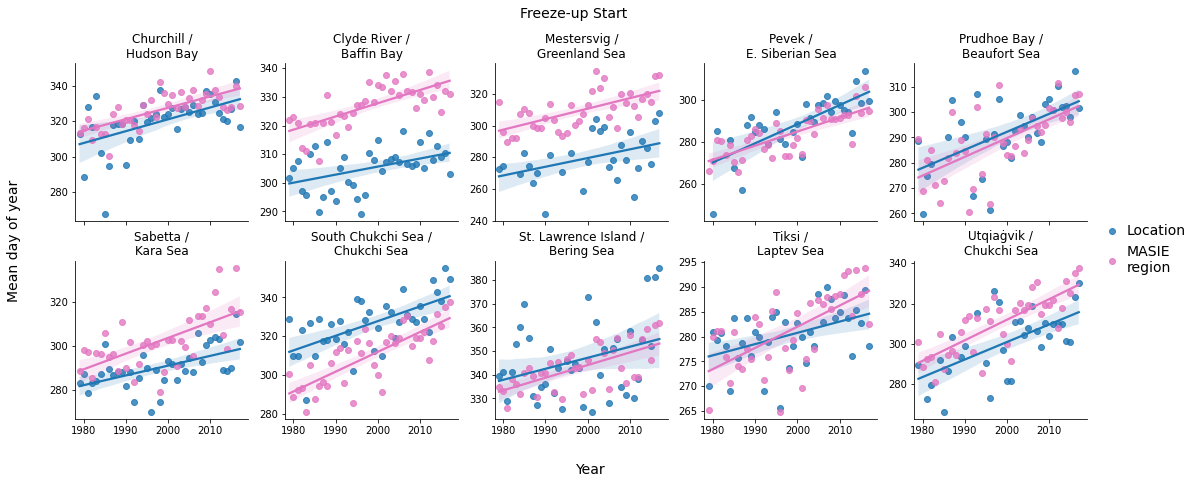

In [18]:
print("Creating freeze-up start point-of-interest / MASIE comparison trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

poi_masie_trends_setup()

output_format = "png"
#output_format = "eps"

indicator = "Freeze-up Start"

mcf.make_masie_poi_trends_plots(
    poi_masie_df,
    indicator,
    content_dir,
    output_format,
)

### Freeze-up end

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_freezeup_end.png


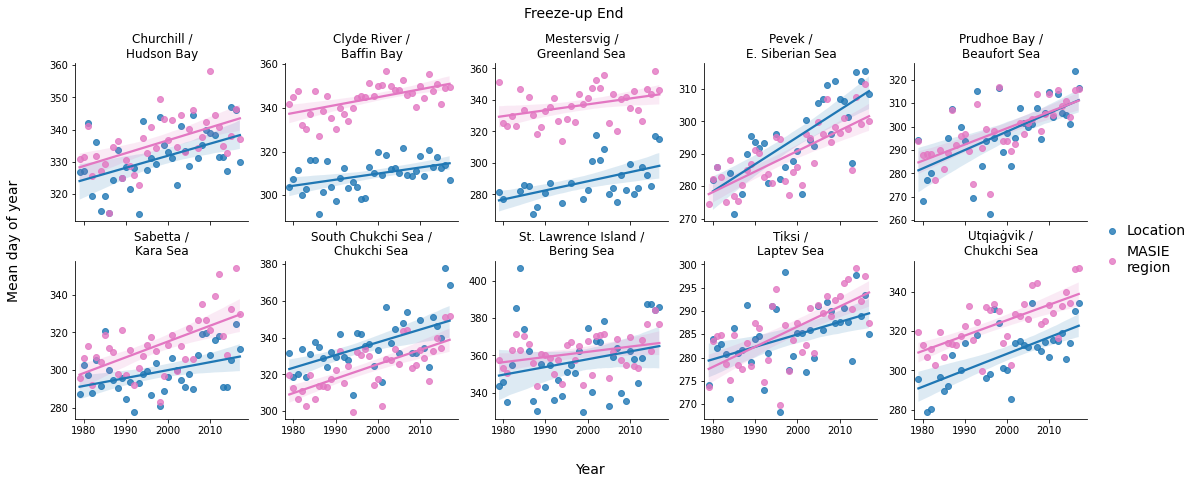

In [19]:
print("Creating freeze-up end point-of-interest / MASIE comparison trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

poi_masie_trends_setup()

output_format = "png"
#output_format = "eps"

indicator = "Freeze-up End"

mcf.make_masie_poi_trends_plots(
    poi_masie_df,
    indicator,
    content_dir,
    output_format,
)

## Setup for MASIE trends plots

Run the cell below before running any of the cells which generate trends plots for MASIE regions.

In [20]:
def masie_trends_setup():
    global fubu
    global orac
    global masie_polys
    global affine
    global zs_df
    
    try: fubu
    except NameError: 
        fubu = mcf.load_fubu(fubu_fp)

    try: orac
    except NameError: 
        orac = mcf.load_orac(orac_fp, fubu)
        
    try: masie_polys
    except NameError:
        masie_polys = mcf.get_masie_polys(masie_fp)

    try: affine
    except NameError:
        affine = mcf.get_fubu_affine(fubu_fp)
    
    try: zs_df
    except NameError:
        zs_df = mcf.run_zonal_stats(fubu, orac, masie_polys, affine)
        
    return zs_df

## MASIE trends plots

### Break-up start

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_breakup_start_trends_plots.png


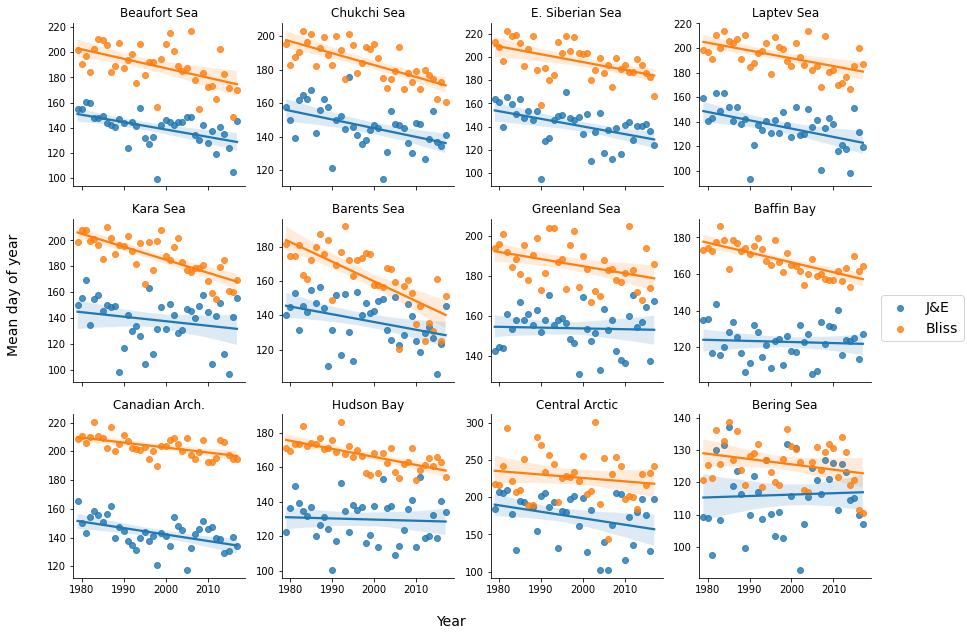

In [21]:
print("Creating break-up start MASIE trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

masie_trends_setup()

output_format = "png"
#output_format = "eps"

masie_lm = mcf.make_masie_trends_plots(
    zs_df, 
    "breakup_start", 
    content_dir.joinpath(f"masie_breakup_start_trends_plots.{output_format}")
)

### Break-up end

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_breakup_end_trends_plots.png


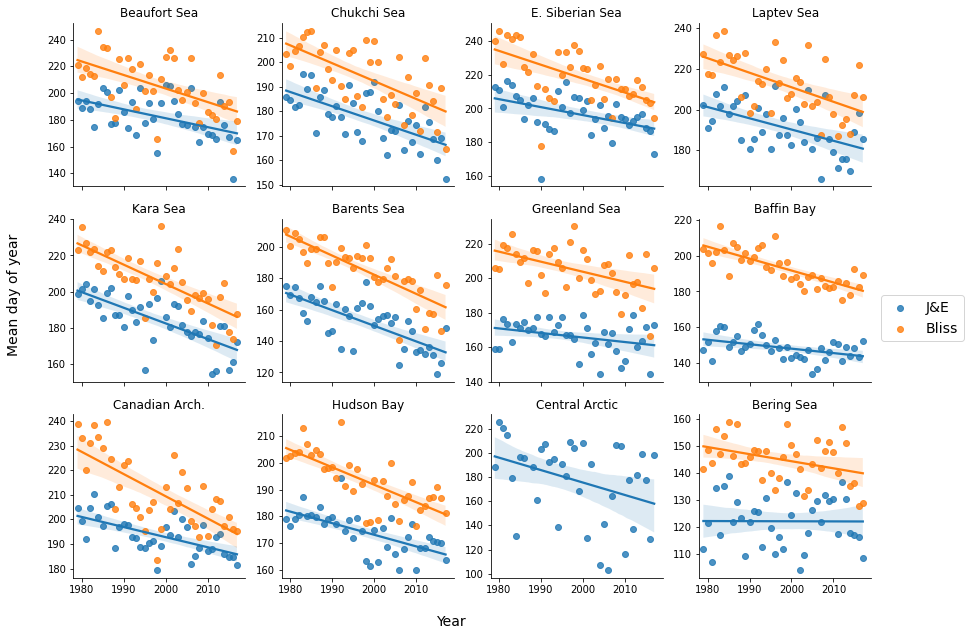

In [22]:
print("Creating break-up end MASIE trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

masie_trends_setup()

output_format = "png"
#output_format = "eps"

masie_lm = mcf.make_masie_trends_plots(
    zs_df, 
    "breakup_end", 
    content_dir.joinpath(f"masie_breakup_end_trends_plots.{output_format}")
)

### Freeze-up start

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_freezeup_start_trends_plots.png


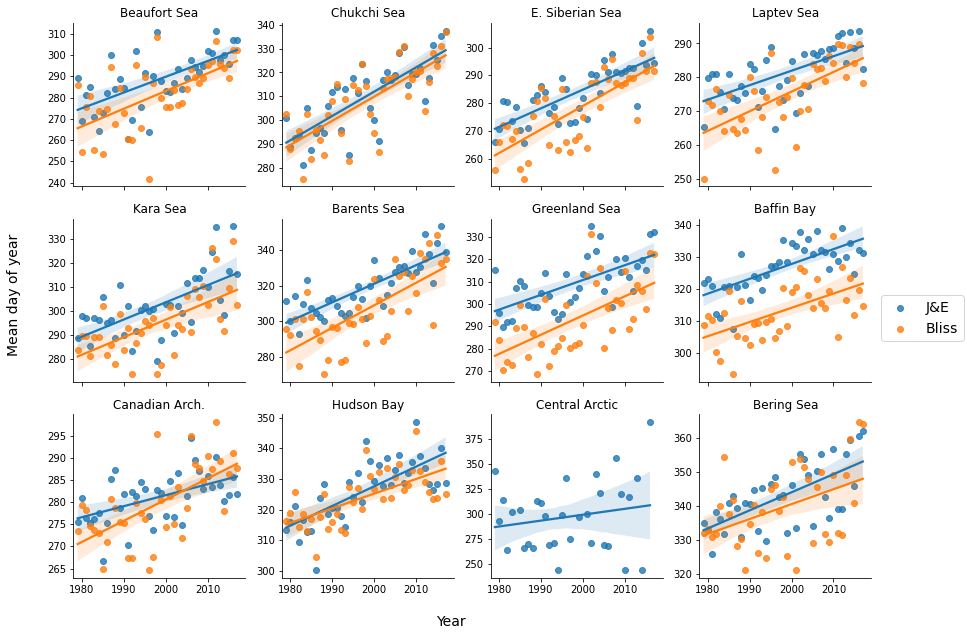

In [23]:
print("Creating freeze-up start MASIE trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

masie_trends_setup()

output_format = "png"
#output_format = "eps"

masie_lm = mcf.make_masie_trends_plots(
    zs_df, 
    "freezeup_start", 
    content_dir.joinpath(f"masie_freezeup_start_trends_plots.{output_format}")
)

### Freeze-up end

/workspace/UA/kmredilla/seaice_noaa_indicators/envs/default/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_freezeup_end_trends_plots.png


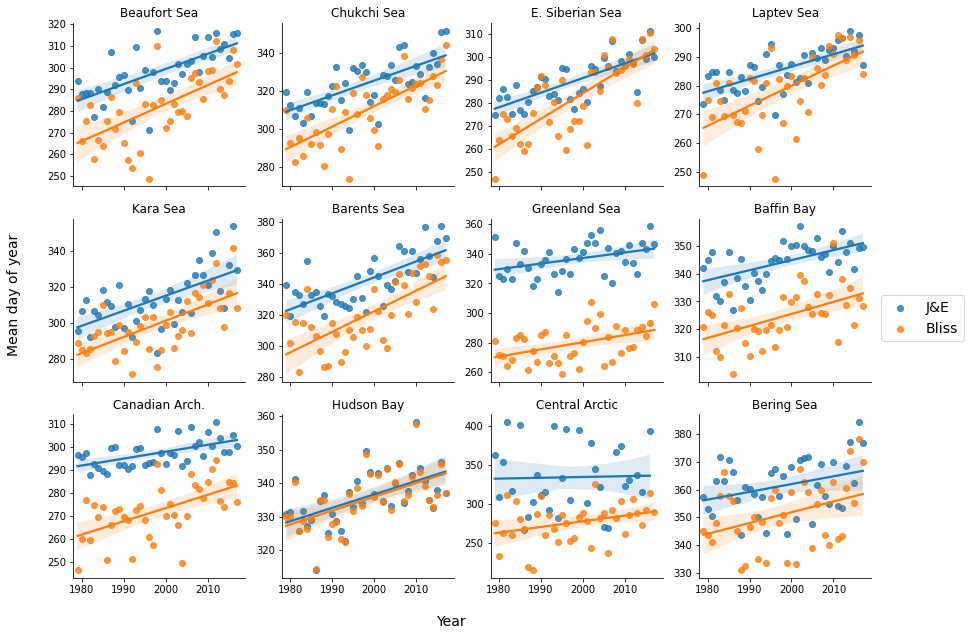

In [24]:
print("Creating freeze-up end MASIE trend plots", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

masie_trends_setup()

output_format = "png"
#output_format = "eps"

masie_lm = mcf.make_masie_trends_plots(
    zs_df, 
    "freezeup_end", 
    content_dir.joinpath(f"masie_freezeup_end_trends_plots.{output_format}")
)

## MASIE trends results table

In [30]:
print("Creating MASIE trends results table", file=terminal_output, flush=True, end="...")
tic = time.perf_counter()

masie_trends_setup()

import pandas as pd
import numpy as np
from scipy import stats

# discard regions with no indicators
zs_df = zs_df[~np.isnan(zs_df["mean_date"])]
rows = []
for groups, df in zs_df.groupby(["region", "group", "indicator"]):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df["year"], df["mean_date"])
    if p_value < 0.01:
        p_value = "< 0.01**"
    elif p_value <= 0.05:
        p_value = str(round(p_value, 2)) + "*"
    else:
        p_value = str(round(p_value, 2))
    
    rows.append([*groups, round(slope, 1), round(r_value, 2), p_value])

masie_lm_results = pd.DataFrame(rows, columns=["Region", "Indicator Group", "Indicator", "Slope", "r2", "p"])
masie_trends_results_fp = content_dir.joinpath("masie_trends_results_table.csv")
masie_lm_results.to_csv(masie_trends_results_fp)
print(f"MASIE trends results written to {masie_trends_results_fp}.", file=terminal_output, flush=True)
masie_lm_results

MASIE trends results written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_trends_results_table.csv


,Region,Indicator Group,Indicator,Slope,r2,p
0,Baffin Bay,Bliss,Day of Advance,0.4,0.57,< 0.01**
1,Baffin Bay,Bliss,Day of Closing,0.4,0.52,< 0.01**
2,Baffin Bay,Bliss,Day of Opening,-0.5,-0.74,< 0.01**
3,Baffin Bay,Bliss,Day of Retreat,-0.7,-0.77,< 0.01**
4,Baffin Bay,J&E,Break-up End,-0.2,-0.44,< 0.01**
...,...,...,...,...,...,...
89,Laptev Sea,Bliss,Day of Retreat,-0.7,-0.58,< 0.01**
90,Laptev Sea,J&E,Break-up End,-0.6,-0.52,< 0.01**
91,Laptev Sea,J&E,Break-up Start,-0.7,-0.48,< 0.01**
92,Laptev Sea,J&E,Freeze-up End,0.4,0.68,< 0.01**
